In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ElemT
import functools
from itertools import count, filterfalse
from scipy import stats
import scipy.optimize as optimize
from IPython.display import Math, Markdown
import emcee

## Misc Functions

In [2]:
g = np.diag([-1., -1., -1., 1.])

def invM(x):
    k = np.sum(np.array(x)[::,6:10],axis=0)
    return np.sqrt((k)@g@(k))

def pT(x):
    return np.sqrt(x[6]**2+x[7]**2)

def m(x):
    return x[6:10]@g@x[6:10]

def ET(x):
    return np.sqrt(m(x)+pT(x)**2)

def cosθ(x):
    return x[8]/np.sqrt(x[6]**2+x[7]**2+x[8]**2)

In [3]:
def breitwigner(M, k, E, Γ):
    return k/((E**2-M**2)**2+(M**2)*(Γ**2))

In [4]:
filename_w = "/home/davyd/installin/MG5_aMC_v2_6_5/wboson2/Events/run_01/unweighted_events.lhe"
filename_z = "/home/davyd/installin/MG5_aMC_v2_6_5/classsim1/Events/run_01/unweighted_events.lhe"

In [5]:
def parse_child(event):
    initialpart = []
    interpart = []
    finalpart = []
    for line in event[1].text[8:].splitlines()[1:]:
        part = list(map(lambda x,y: int(x) if y<6 else float(x), line.lstrip().split(), count()))
        {-1:initialpart, 2:interpart, 1:finalpart}[part[1]].append(np.array(part))
    return finalpart

In [6]:
def final_particles_gen(filename):
    yield from map(parse_child,filter(lambda x: x[1].tag=='event', ElemT.iterparse(filename)))

In [7]:
eμ = {11, -11, 13, -13}

In [8]:
def eμ_generator(filename):
    final_parts = final_particles_gen(filename)
    return map(list, (filter(lambda x: int(x[0]) in eμ, event) for event in final_parts))

## Z boson

In [9]:
eμs = eμ_generator(filename_z)
invmasses = list(map(invM,eμs))

In [10]:
n, bins = np.histogram(invmasses, bins=100,range=(85,100), density=True)
bins = bins[:-1]

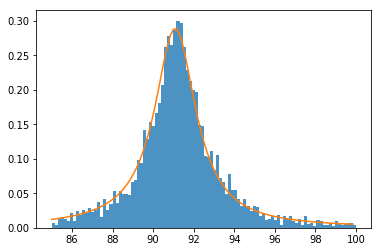

In [11]:
popt, pcov = optimize.curve_fit(breitwigner, bins, n)

popt = np.abs(popt)
plt.hist(invmasses, bins=100,range=(85,100),alpha=.8, density=True)
plt.plot(bins, breitwigner(bins, *popt));

In [12]:
Markdown("So we obtain a value for the Z mass of {:.3} GeV and a width of {:.3} GeV".format(popt[1], popt[2]))

So we obtain a value for the Z mass of 91.1 GeV and a width of 2.47 GeV

### W$^\pm$ Boson

In [13]:
eμs = eμ_generator(filename_w)
eμs = list(map(lambda x: x[0], eμ_generator(filename_w)))

In [14]:
transverse = list(filterfalse(np.isnan, map(lambda x: np.sqrt(2*pT(x)*pT(x)*(1-cosθ(x))), eμs)))

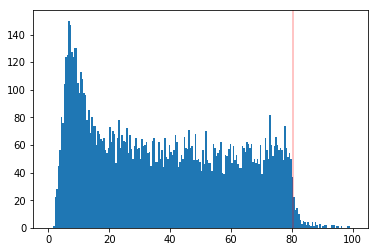

In [15]:
plt.hist(transverse, bins=200, range=(0, 100))
plt.axvline(80.385, color='r', alpha=.3);

Not sure quite how to interpret this as an exact value, but by overlaying the true value, it seems that the cutoff is accurately reproduced at around the true value, but I have no idea how to obtain the resonance width.